In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
import os
from torchvision.transforms import v2


## Train the model

In [3]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

num_classes = 8
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224,scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'CNN_Dataset/sports_data_9_cls'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)


device = torch.device("cpu")
vgg16.to(device)


num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(image_datasets['train'])
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')


In [4]:
device = torch.device("cpu")
vgg16.to(device)

num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(image_datasets['train'])
    
    vgg16.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * inputs.size(0)
    
    val_loss = validation_loss / len(image_datasets['test'])
    

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vgg16.state_dict(), 'best_vgg16_model_9_cls.pth')

## Load the model

In [5]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = models.vgg16(pretrained=False)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 8)

model.load_state_dict(torch.load('best_vgg16_model_9_cls.pth'))
model.eval()

/home/akanksha/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akanksha/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

/home/akanksha/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akanksha/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


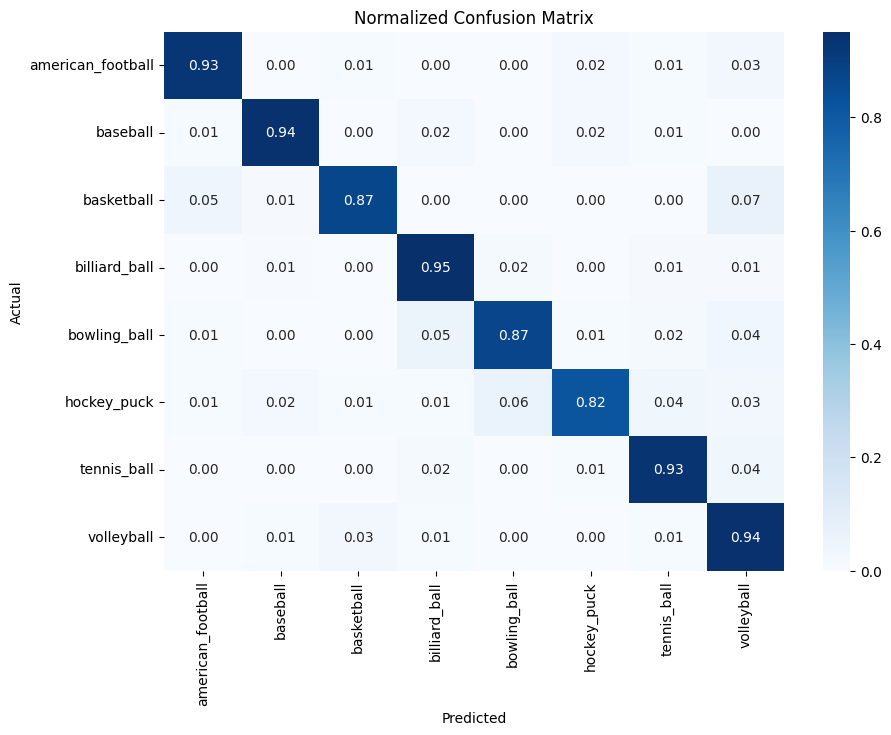

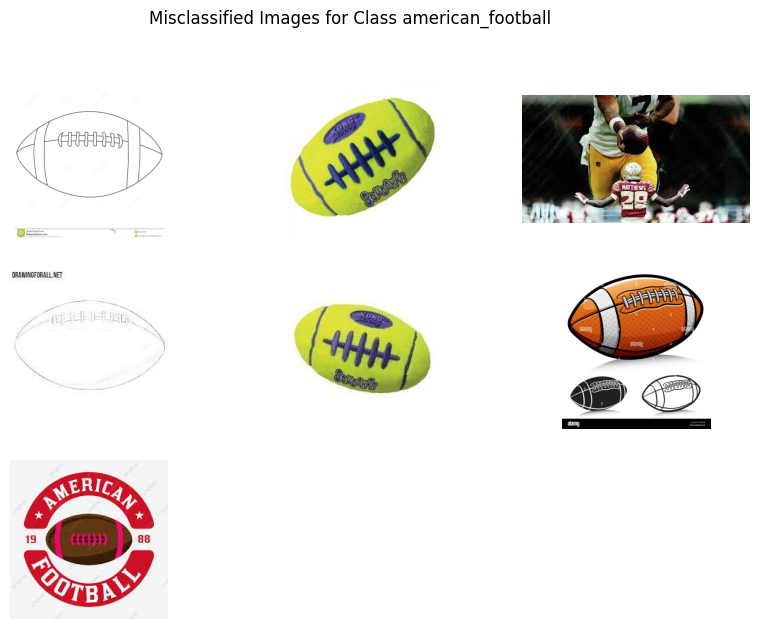

In [9]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple[0], original_tuple[1], path)
        return tuple_with_path

def load_model(model_path):
    model = models.vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(4096, 8)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def prepare_data(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = ImageFolderWithPaths(root=data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return test_loader, test_dataset

def compute_confusion_and_misclassifications(model, dataloader, target_class):
    y_true = []
    y_pred = []
    img_paths = []
    
    with torch.no_grad():
        for inputs, labels, paths in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
            img_paths.extend(paths)
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    
    misclassified = []
    
    for true, pred, path in zip(y_true, y_pred, img_paths):
        if true == target_class and pred != target_class:
            misclassified.append(path)
    
    return cf_matrix, misclassified

def normalize_confusion_matrix(cf_matrix):
    normalized_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    return normalized_matrix

def plot_confusion_matrix(cf_matrix, class_names, normalized=True):
    plt.figure(figsize=(10, 7))
    if normalized:
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'
    sns.heatmap(cf_matrix, annot=True, fmt='.2f' if normalized else 'd', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def display_images(image_paths, title):
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(title)
    
    for i, img_path in enumerate(image_paths[:9]):
        img = Image.open(img_path)
        ax = fig.add_subplot(3, 3, i + 1)
        ax.imshow(img)
        ax.axis('off')
    
    plt.show()

# Load the model
model_path = 'best_vgg16_model_9_cls.pth'
model = load_model(model_path)

data_dir = 'CNN_Dataset/sports_data_9_cls/test/'
test_loader, test_dataset = prepare_data(data_dir)

#class index
target_class = 0

cf_matrix, misclassified_images = compute_confusion_and_misclassifications(model, test_loader, target_class)

normalized_cf_matrix = normalize_confusion_matrix(cf_matrix)

plot_confusion_matrix(normalized_cf_matrix, test_dataset.classes, normalized=True)

display_images(misclassified_images, f"Misclassified Images for Class {test_dataset.classes[target_class]}")

## LRP Explanations

american_football_58.jpg
(224, 224, 3)


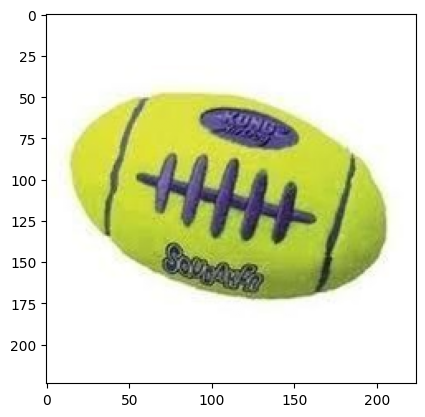

<Figure size 400x400 with 0 Axes>

/home/akanksha/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akanksha/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ 4.50888    -0.98695934 -4.3577795  -3.2045934  -6.2037272  -5.2788734
  9.2349615   7.884971  ]
Index of the maximum element in the list is:  6
predicted class6
0


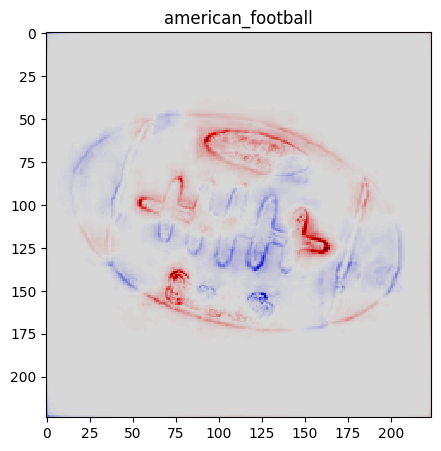

1


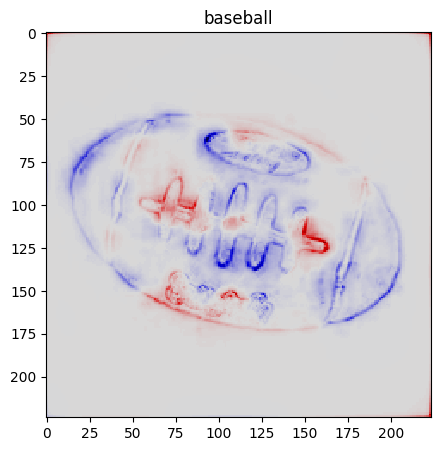

2


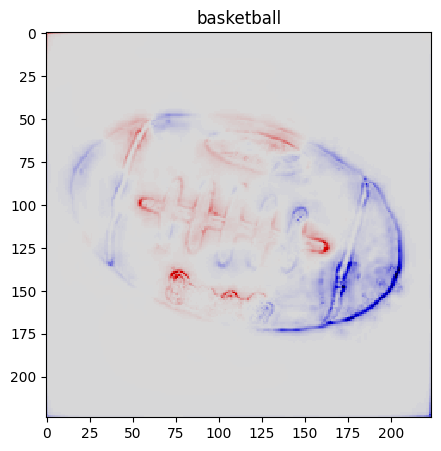

3


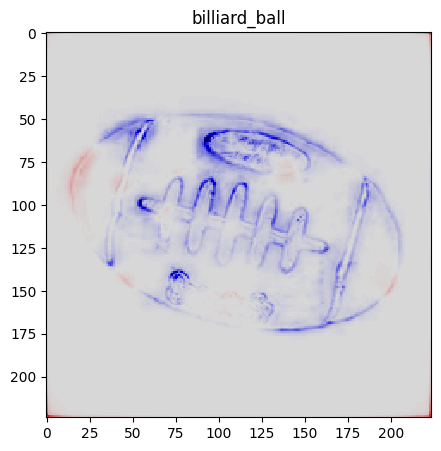

4


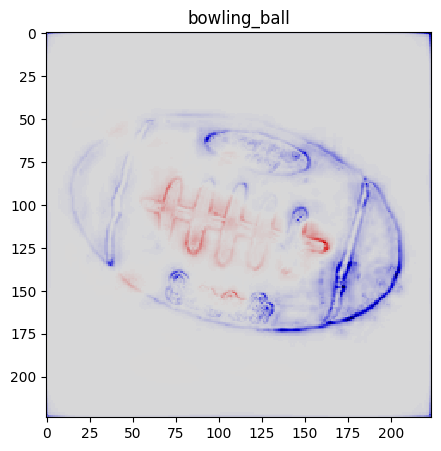

5


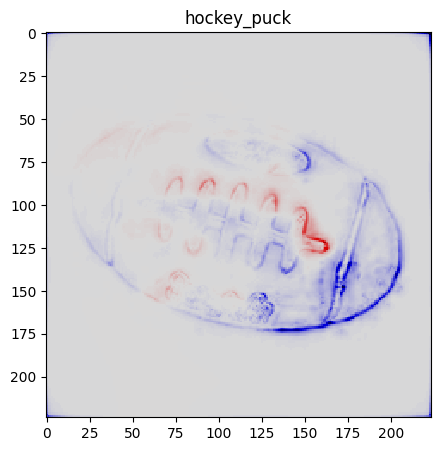

6


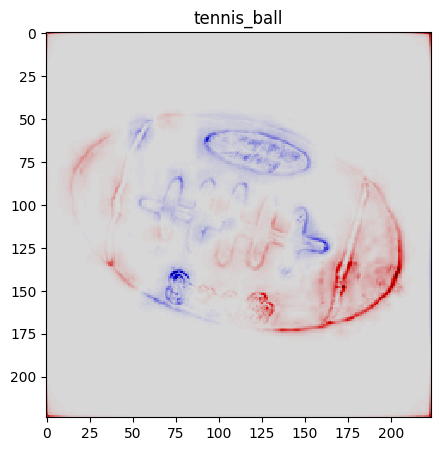

7


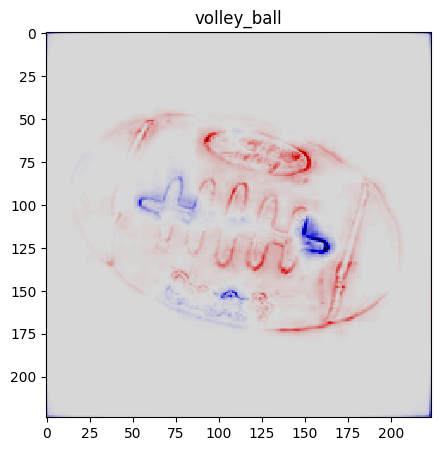

american_football_145.jpg
(224, 224, 3)


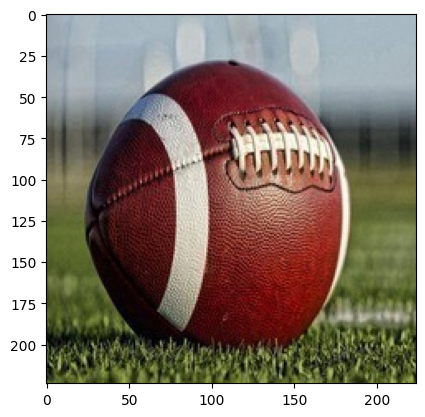

<Figure size 400x400 with 0 Axes>

[ 1.8260483e+01  1.4302841e+00 -1.5895866e-02 -6.3906360e+00
 -3.2519016e-01 -6.3622046e-01 -7.5023928e+00 -7.8962617e+00]
Index of the maximum element in the list is:  0
predicted class0
0


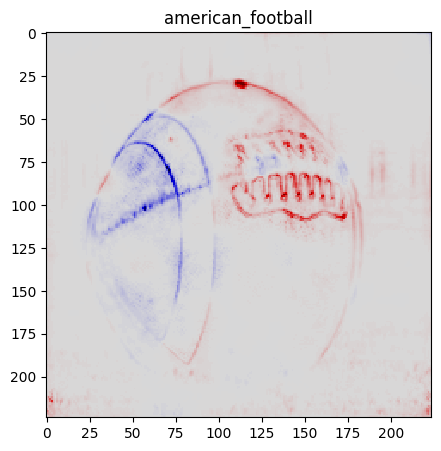

1


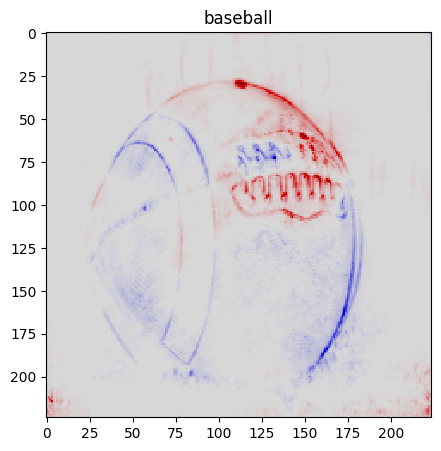

2


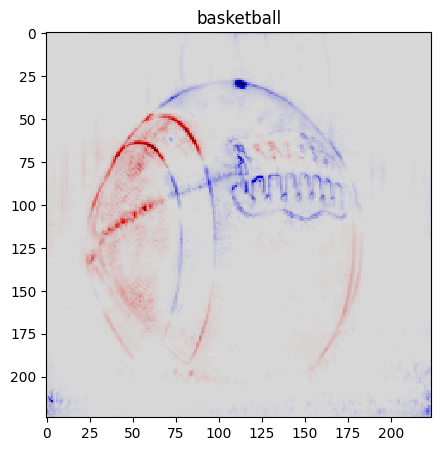

3


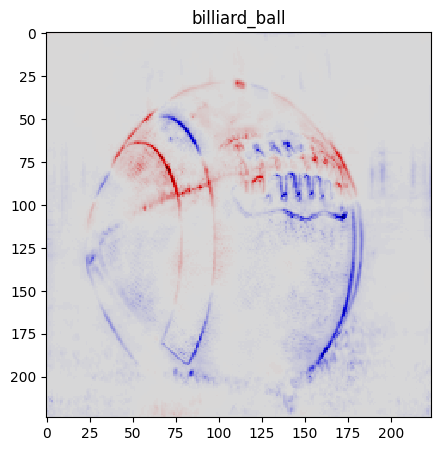

4


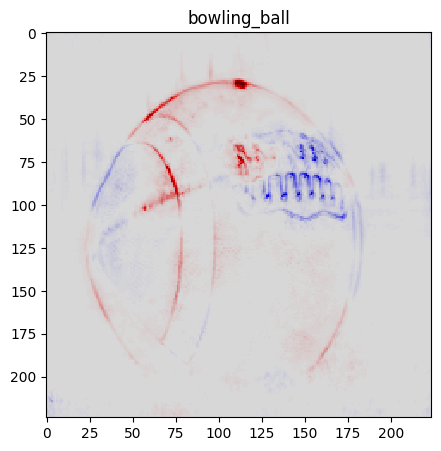

5


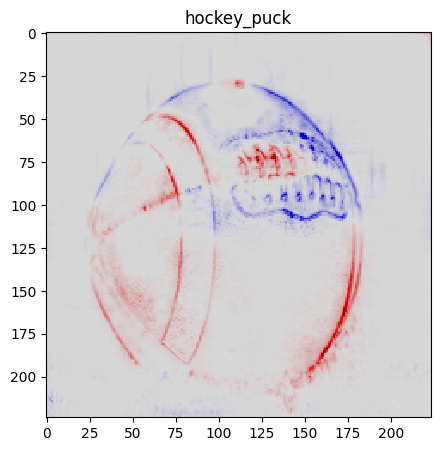

6


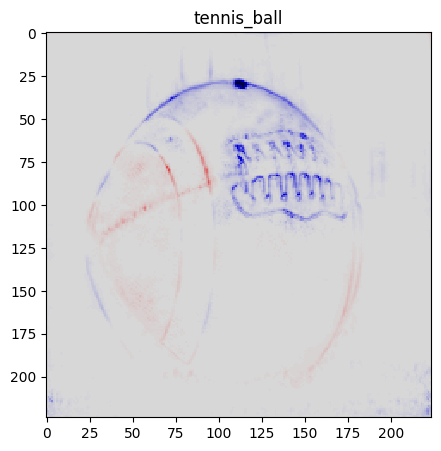

7


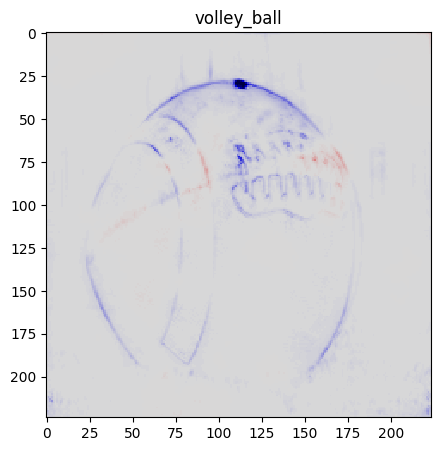

american_football_181.jpg
(224, 224, 3)


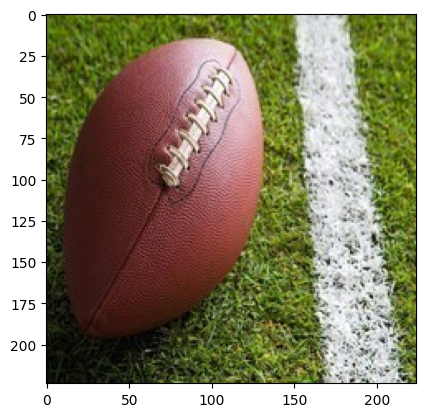

<Figure size 400x400 with 0 Axes>

[29.3884     6.6156826 -6.10462   -9.460449  -6.9527364 -2.3375313
 -4.230136  -5.3751664]
Index of the maximum element in the list is:  0
predicted class0
0


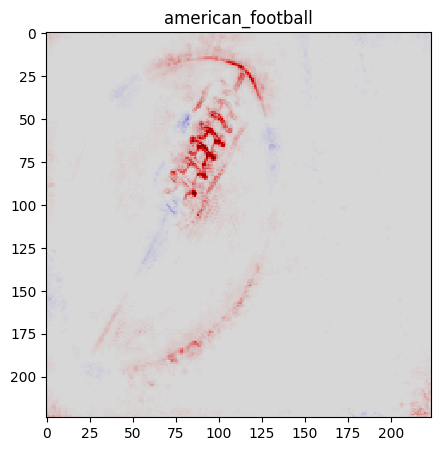

1


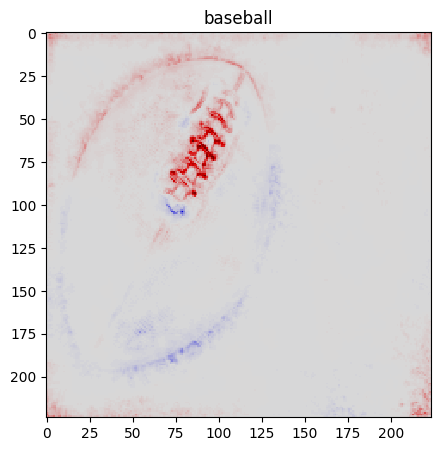

2


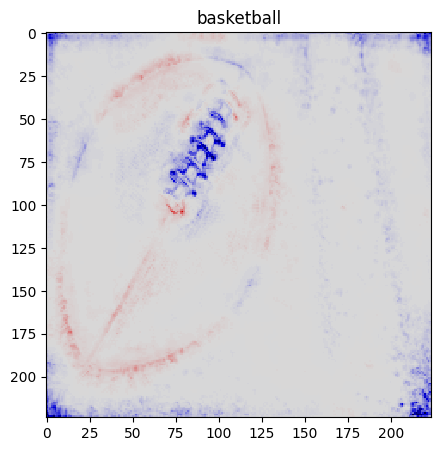

3


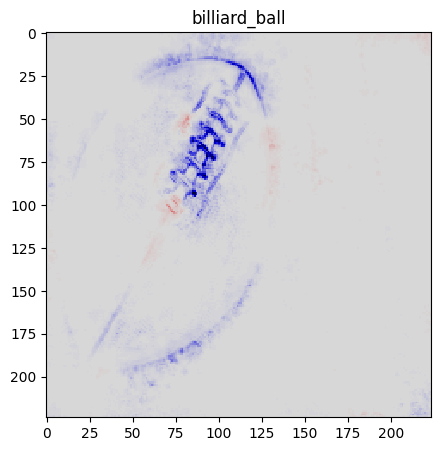

4


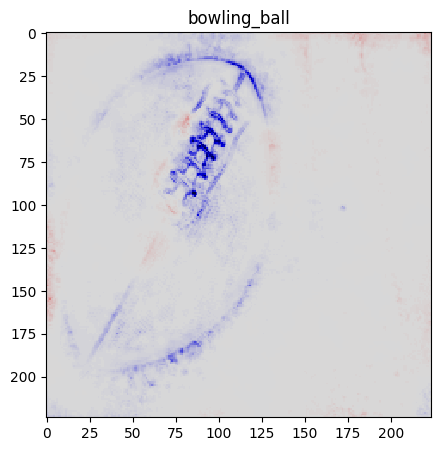

5


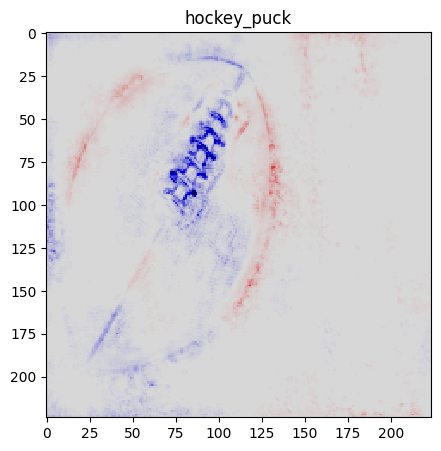

6


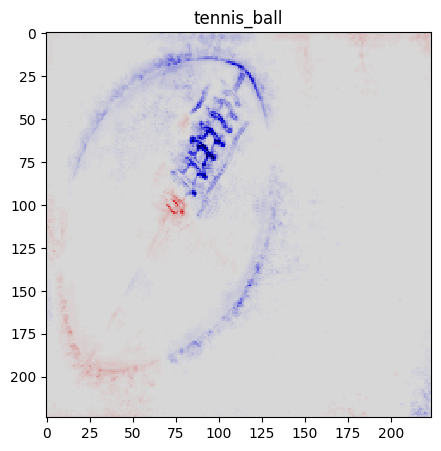

7


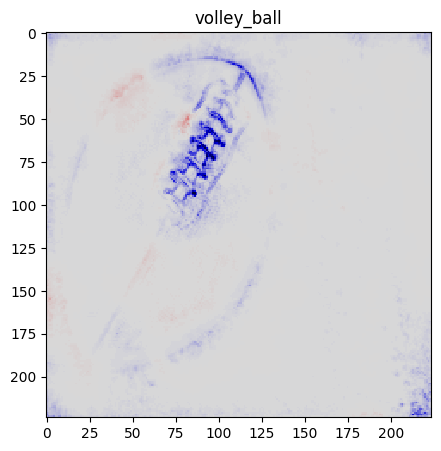

tennis_195.jpg
(224, 224, 3)


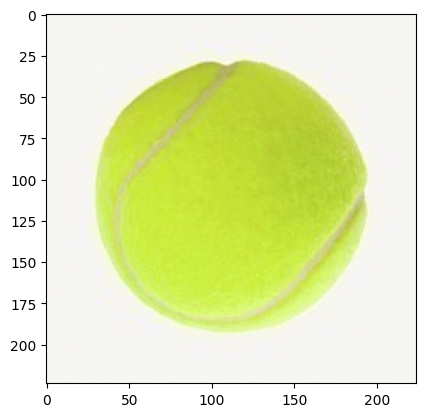

<Figure size 400x400 with 0 Axes>

[ -6.424122    -4.9445467   -5.626794    -2.2854273   -5.042359
 -10.271682    35.74213      0.47097468]
Index of the maximum element in the list is:  6
predicted class6
0


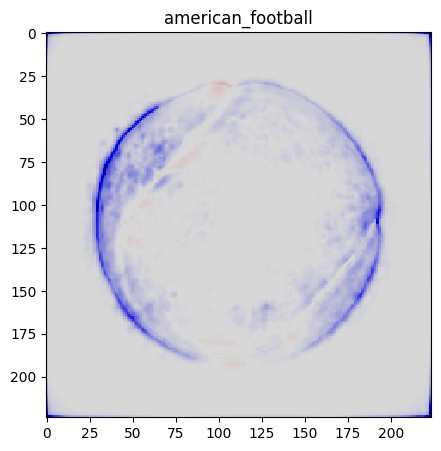

1


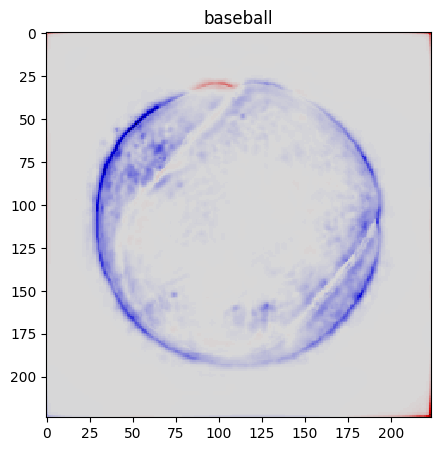

2


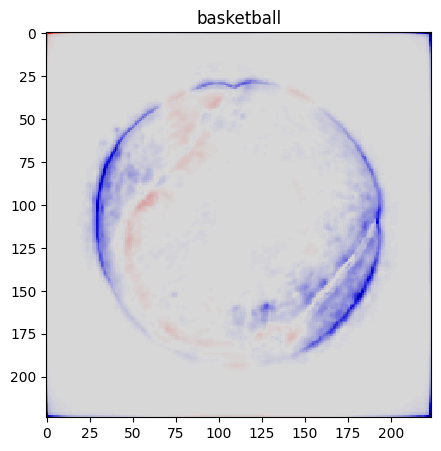

3


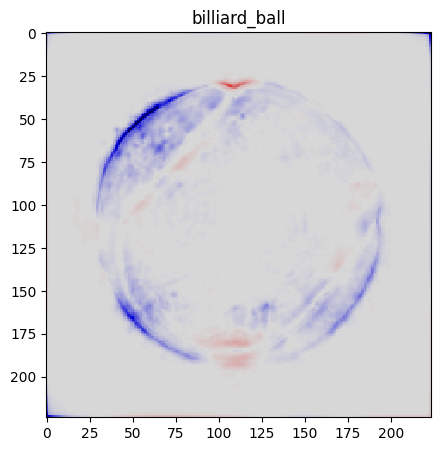

4


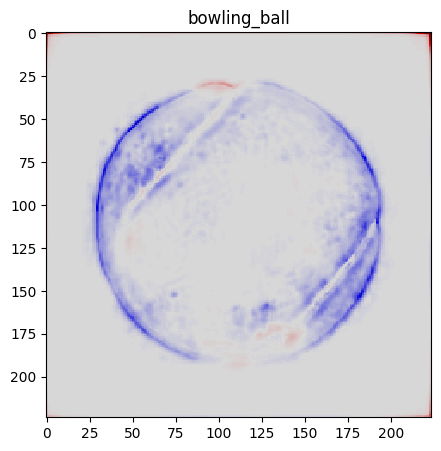

5


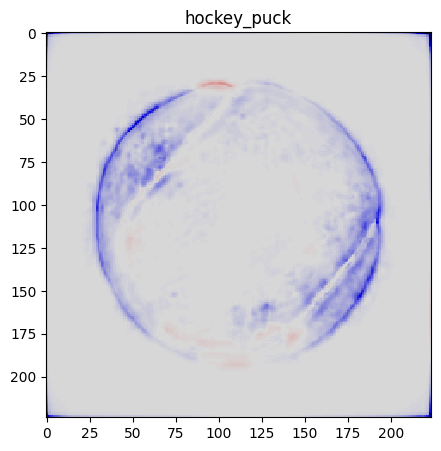

6


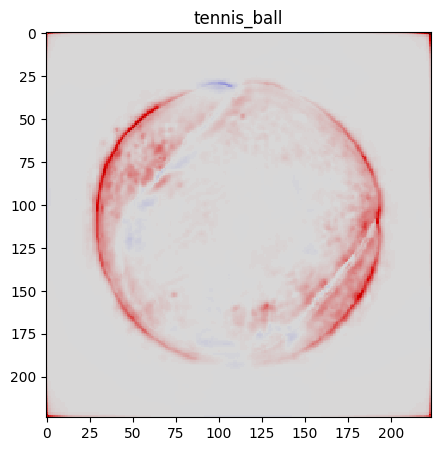

7


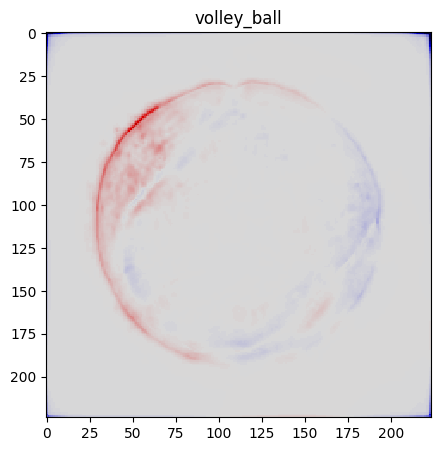

tennis_892.jpg
(224, 224, 3)


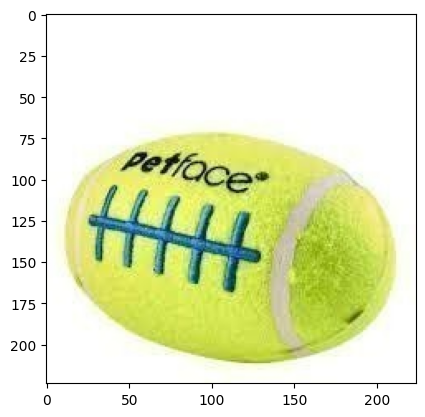

<Figure size 400x400 with 0 Axes>

[ 1.2313253  2.423309  -6.366003   2.3507192 -8.882555  -5.901517
 19.681267  -4.3777056]
Index of the maximum element in the list is:  6
predicted class6
0


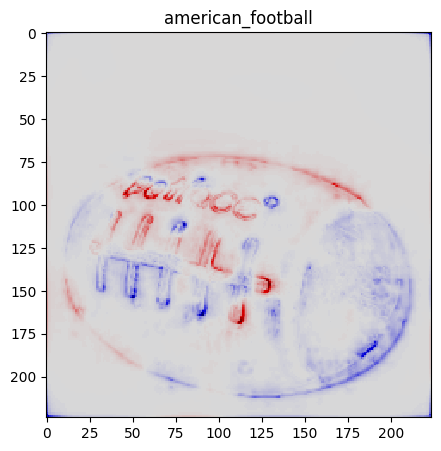

1


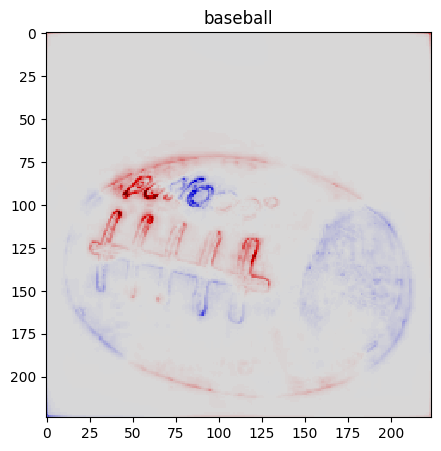

2


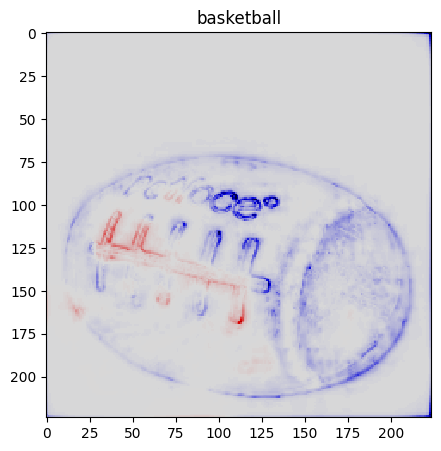

3


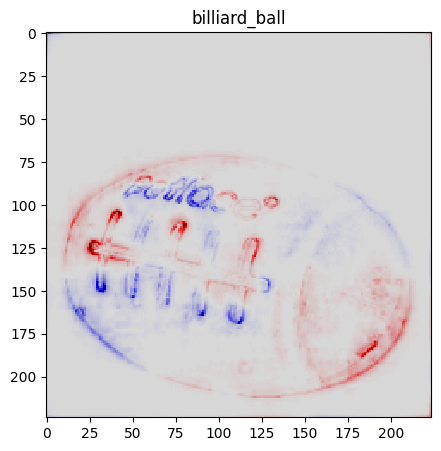

4


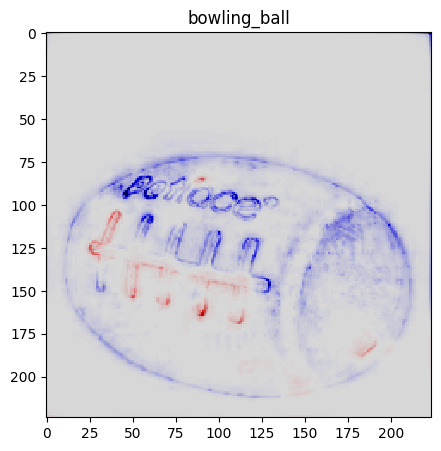

5


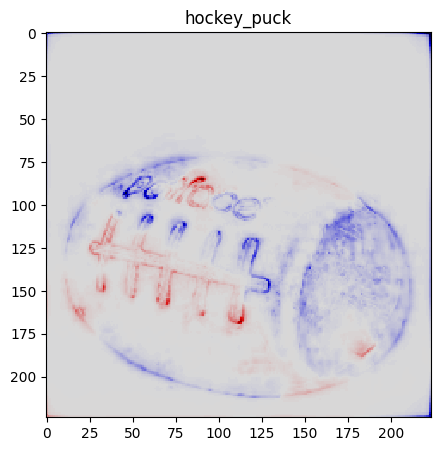

6


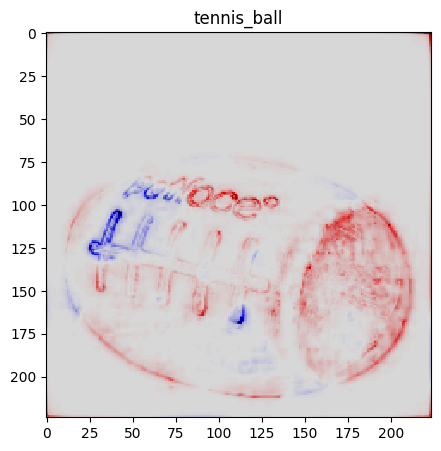

7


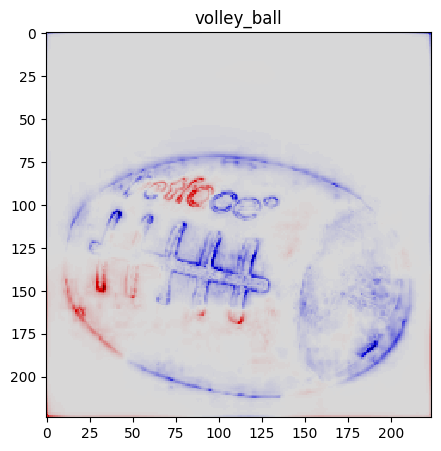

tennis_824.jpg
(224, 224, 3)


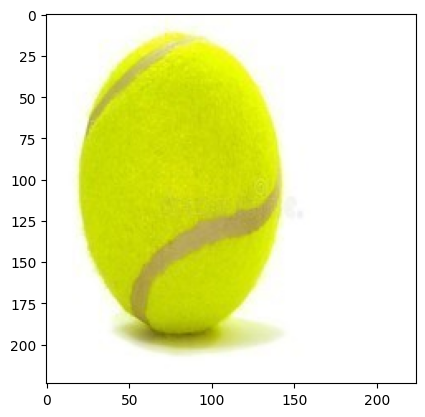

<Figure size 400x400 with 0 Axes>

[ -9.911494   -5.9315825  -9.330778   -8.854477  -11.7804575  -9.295617
  54.393818    4.2782235]
Index of the maximum element in the list is:  6
predicted class6
0


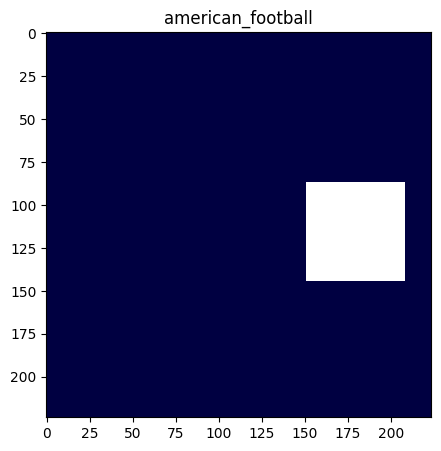

1


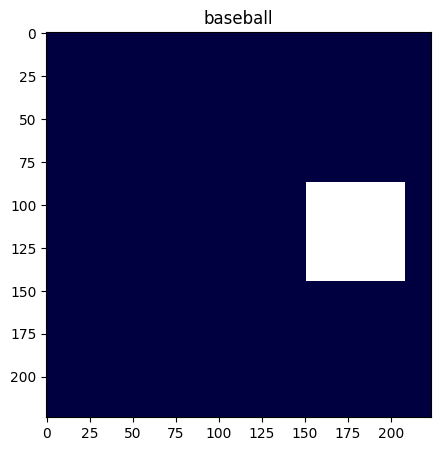

2


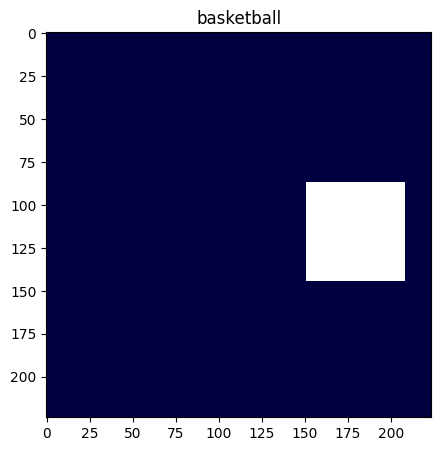

3


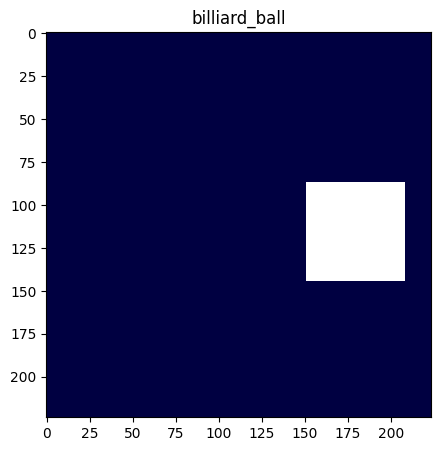

4


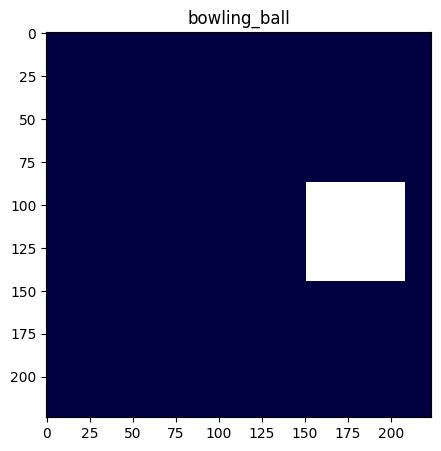

5


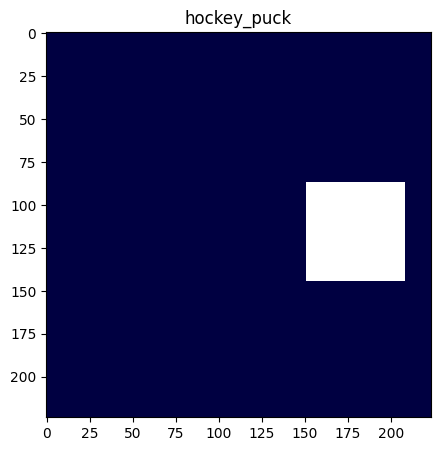

6


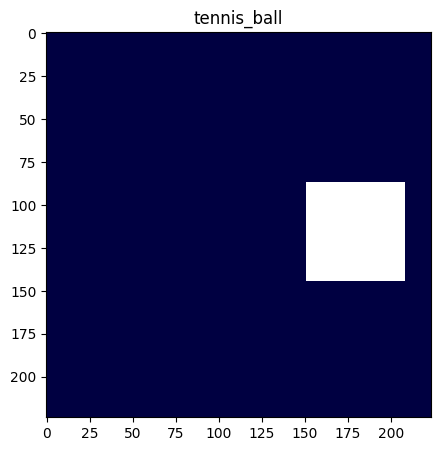

7


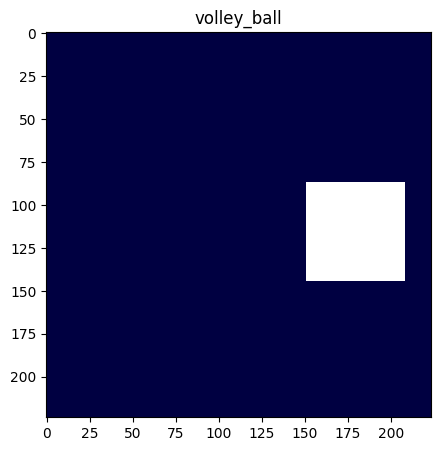

In [10]:
import cv2
import numpy
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import os
from os import listdir
 
folder_dir = "CNN_Dataset/sports_data_9_cls/test/"
for images in os.listdir(folder_dir):
 
    if (images.endswith(".jpg")):
        print(images)
        img = mpimg.imread(folder_dir+images)
        img = numpy.array(cv2.imread(folder_dir+images))[:,:,::-1]/255.0
        print(img.shape)
        imgplot = plt.imshow(img)
        plt.figure(figsize=(4,4))
        plt.show()
        
        
        import torch
        
        mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
        std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
        
        X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
        
        import utils
        from torchvision import datasets, models
        from torch import nn, optim
        import os
        vgg16 = models.vgg16(pretrained=True)
        num_classes = 8
        vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
        
        vgg16.load_state_dict(torch.load('CNN_Dataset/best_vgg16_model_9_cls.pth'))
        
        
        layers = list(vgg16._modules['features']) + utils.toconv(list(vgg16._modules['classifier']))
        # print(layers)
        L = len(layers)

        A = [X]+[None]*L
        for l in range(L): A[l+1] = layers[l].forward(A[l])
        
        scores = numpy.array(A[-1].data.contiguous().view(-1))
        print(scores)
        ind = 0   
        max_element = scores[0]
         
        for i in range (1,len(scores)):
            if scores[i] > max_element:
                max_element = scores[i]
                ind = i
        print("Index of the maximum element in the list is: ",ind)
        
        print('predicted class'+str(ind))
        
        ind = numpy.argsort(-scores)
        
        for clss in range(0,8):
            print(clss)
            T = torch.FloatTensor((1.0*(numpy.arange(8)==clss).reshape([1,8,1,1])))
            
            R = [None]*L + [(A[-1]*T).data]
            
            
            for l in range(1,L)[::-1]:
                
                A[l] = (A[l].data).requires_grad_(True)
            
                if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)
            
                if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
            
                    if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
                    if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
                    if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9
            
                    z = incr(utils.newlayer(layers[l],rho).forward(A[l]))
                    s = (R[l+1]/z).data                                    
                    (z*s).sum().backward(); c = A[l].grad                  
                    R[l] = (A[l]*c).data                             
                    
                else:
                    
                    R[l] = R[l+1]
            
            for i,l in enumerate([1]):
                if clss==0:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'american_football')
                elif clss==1:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'baseball')
                elif clss==2:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'basketball')
                elif clss==3:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'billiard_ball')
                elif clss==4:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'bowling_ball')
                elif clss==5:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'hockey_puck')
                elif clss==6:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'tennis_ball')
                elif clss==7:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'volley_ball')
                elif clss==8:
                    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),5,5,'volley_ball')

In [11]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image


vgg16 = models.vgg16(pretrained=True)
num_classes = 8 
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=8)

vgg16.load_state_dict(torch.load('CNN_Dataset/best_vgg16_model_9_cls.pth'))
vgg16.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

import pandas as pd

Predicted_class=[]
Class_probabilities=[]
image=[]

folder_dir = "CNN_Dataset/_testing_data/test/table_tennis_ball/"
for images in os.listdir(folder_dir):
    
    print(images)

    img = Image.open(folder_dir+images)
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)
    
    device = torch.device("cpu")
    model = vgg16.to(device)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    
    _, predicted_class = torch.max(probabilities, dim=0)
    
    print(f"Predicted class: {predicted_class.item()}")
    print(f"Class probabilities: {probabilities.cpu().numpy()[predicted_class.item()]}")

    Class_probabilities.append(probabilities.cpu().numpy()[predicted_class.item()])
    Predicted_class.append(predicted_class.item())
    image.append(images)


table_tennis_ball_660.jpg
Predicted class: 3
Class probabilities: 0.9999982118606567
table_tennis_ball_140.jpg
Predicted class: 3
Class probabilities: 0.6878584027290344
table_tennis_ball_539.jpg
Predicted class: 3
Class probabilities: 0.9824452996253967
table_tennis_ball_938.jpg
Predicted class: 3
Class probabilities: 1.0
table_tennis_ball_852.jpg
Predicted class: 6
Class probabilities: 0.9999377727508545
table_tennis_ball_906.jpg
Predicted class: 6
Class probabilities: 0.9667811393737793
table_tennis_ball_54.jpg
Predicted class: 3
Class probabilities: 0.9562215209007263
table_tennis_ball_1102.jpg
Predicted class: 1
Class probabilities: 0.5899198651313782
table_tennis_ball_223.jpg
Predicted class: 3
Class probabilities: 0.9206411838531494
table_tennis_ball_155.jpg
Predicted class: 3
Class probabilities: 0.9852065443992615
table_tennis_ball_619.jpg
Predicted class: 3
Class probabilities: 0.9999880790710449
table_tennis_ball_761.jpg
Predicted class: 3
Class probabilities: 1.0
table_tenn

In [12]:
df = pd.DataFrame(columns=['Images','Predicted_class','Class_probabilities'])

df['Predicted_class']=Predicted_class
df['Class_probabilities']=Class_probabilities
df['Images']=image

display(df)

,Images,Predicted_class,Class_probabilities
0,table_tennis_ball_660.jpg,3,0.999998
1,table_tennis_ball_140.jpg,3,0.687858
2,table_tennis_ball_539.jpg,3,0.982445
3,table_tennis_ball_938.jpg,3,1.000000
4,table_tennis_ball_852.jpg,6,0.999938
...,...,...,...
150,table_tennis_ball_731.jpg,3,0.999995
151,table_tennis_ball_706.jpg,3,0.999981
152,table_tennis_ball_2.jpg,0,0.597561
153,table_tennis_ball_122.jpg,0,0.987598


In [13]:
df.loc[df['Predicted_class'] == 0, 'Predicted_class'] = 'american_football'
df.loc[df['Predicted_class'] == 1, 'Predicted_class'] = 'baseball'
df.loc[df['Predicted_class'] == 2, 'Predicted_class'] = 'basketball'
df.loc[df['Predicted_class'] == 3, 'Predicted_class'] = 'billiard_ball'
df.loc[df['Predicted_class'] == 4, 'Predicted_class'] = 'bowling_ball'
df.loc[df['Predicted_class'] == 5, 'Predicted_class'] = 'hockey_puck'
df.loc[df['Predicted_class'] == 6, 'Predicted_class'] = 'tennis_ball'
df.loc[df['Predicted_class'] == 7, 'Predicted_class'] = 'volley_ball'


/tmp/ipykernel_1285035/2587739686.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'american_football' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Predicted_class'] == 0, 'Predicted_class'] = 'american_football'


In [15]:
df['Predicted_class'].value_counts()

Predicted_class
billiard_ball        76
tennis_ball          30
hockey_puck          17
baseball             15
american_football     7
volley_ball           6
bowling_ball          3
basketball            1
Name: count, dtype: int64